<a href="https://colab.research.google.com/github/srinijalanda93/Predictive_Analystics/blob/main/lab6_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn scipy statsmodels pmdarima scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import datetime

# Optional: use pmdarima.auto_arima for automatic ARIMA order selection
try:
    import pmdarima as pm
    has_pmdarima = True
except Exception:
    has_pmdarima = False

plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("darkgrid")

In [ ]:
# User config: choose ticker and date range
TICKER = "AAPL"    # change to "MSFT", "GOOGL", "^GSPC", etc.
START = "2018-01-01"
END   = datetime.date.today().strftime("%Y-%m-%d")  # up to today

# Download
df = yf.download(TICKER, start=START, end=END, progress=False)
print(f"Downloaded {len(df)} rows for {TICKER} from {START} to {END}")
df.head()


Downloaded 1975 rows for AAPL from 2018-01-01 to 2025-11-09


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380985,40.390364,39.677729,39.888708,102223600
2018-01-03,40.373981,40.917835,40.310691,40.444308,118071600
2018-01-04,40.561501,40.664645,40.338803,40.446634,89738400
2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
2018-01-08,40.870930,41.166296,40.772471,40.870930,82271200


In [ ]:
# User config: choose ticker and date range
TICKER = "AAPL"    # change to "MSFT", "GOOGL", "^GSPC", etc.
START = "2018-01-01"
END   = datetime.date.today().strftime("%Y-%m-%d")  # up to today

# Download
df = yf.download(TICKER, start=START, end=END, progress=False)
print(f"Downloaded {len(df)} rows for {TICKER} from {START} to {END}")
df.head()


Downloaded 1975 rows for AAPL from 2018-01-01 to 2025-11-09


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380985,40.390364,39.677729,39.888708,102223600
2018-01-03,40.373981,40.917835,40.310691,40.444308,118071600
2018-01-04,40.561501,40.664645,40.338803,40.446634,89738400
2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
2018-01-08,40.870930,41.166296,40.772471,40.870930,82271200


In [ ]:
# Basic checks
df.info()
df.isna().sum()

# 1. Remove rows with no trading data (if any)
df = df.dropna(how="all")

# 2. Forward/backward fill small gaps in OHLC/Volume if needed
df[['Open','High','Low','Close','Volume']] = df[['Open','High','Low','Close','Volume']].ffill().bfill()

# 3. Remove extreme outliers in 'Close' using z-score (optional)
from scipy import stats
z_scores = np.abs(stats.zscore(df['Close'].fillna(method='ffill').values))
outlier_idx = np.where(z_scores > 5)[0]   # threshold 5 is conservative
if len(outlier_idx)>0:
    print("Outliers found at positions:", outlier_idx)
    df = df.drop(df.index[outlier_idx])

# 4. Ensure Date is index and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1975 entries, 2018-01-02 to 2025-11-07
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1975 non-null   float64
 1   (High, AAPL)    1975 non-null   float64
 2   (Low, AAPL)     1975 non-null   float64
 3   (Open, AAPL)    1975 non-null   float64
 4   (Volume, AAPL)  1975 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 92.6 KB


In [ ]:
df.to_csv(f"{TICKER}_cleaned.csv")


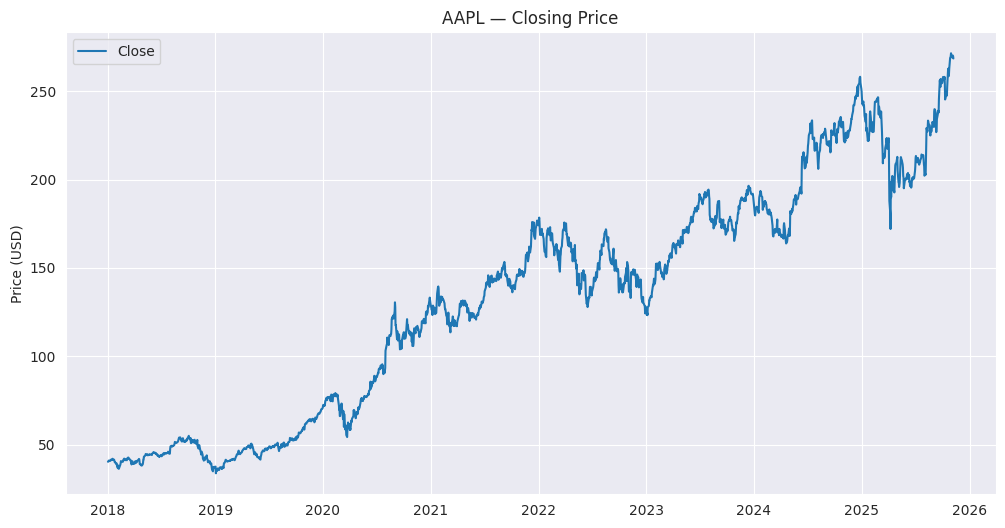

In [ ]:
fig, ax = plt.subplots()
ax.plot(df.index, df['Close'], label='Close')
ax.set_title(f"{TICKER} — Closing Price")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.show()


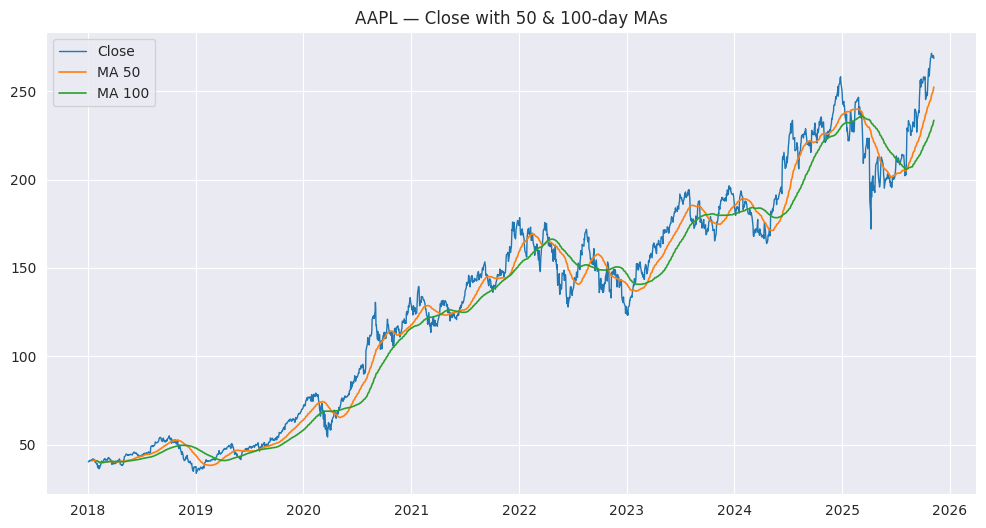

In [ ]:
df['MA50'] = df['Close'].rolling(window=50, min_periods=10).mean()
df['MA100'] = df['Close'].rolling(window=100, min_periods=20).mean()

fig, ax = plt.subplots()
ax.plot(df['Close'], label='Close', linewidth=1)
ax.plot(df['MA50'], label='MA 50', linewidth=1.2)
ax.plot(df['MA100'], label='MA 100', linewidth=1.2)
ax.set_title(f"{TICKER} — Close with 50 & 100-day MAs")
ax.legend()
plt.show()


In [ ]:
# Use scipy find_peaks on close price to get peaks; invert to get dips
close_arr = df['Close'].values
peaks, _ = find_peaks(close_arr, distance=5, prominence=1)   # tune distance/prominence
dips, _  = find_peaks(-close_arr, distance=5, prominence=1)

fig, ax = plt.subplots()
ax.plot(df.index, df['Close'], label='Close')
ax.plot(df.index[peaks], df['Close'].iloc[peaks], "ro", label='Peaks')
ax.plot(df.index[dips], df['Close'].iloc[dips], "go", label='Dips')
ax.set_title(f"{TICKER} — Major peaks (red) and dips (green)")
ax.legend()
plt.show()

# Print top 5 peaks and dips by price/prominence
top_peaks = df['Close'].iloc[peaks].sort_values(ascending=False).head(5)
top_dips  = df['Close'].iloc[dips].sort_values(ascending=True).head(5)
print("Top peaks:\n", top_peaks)
print("Top dips:\n", top_dips)


ValueError: `x` must be a 1-D array

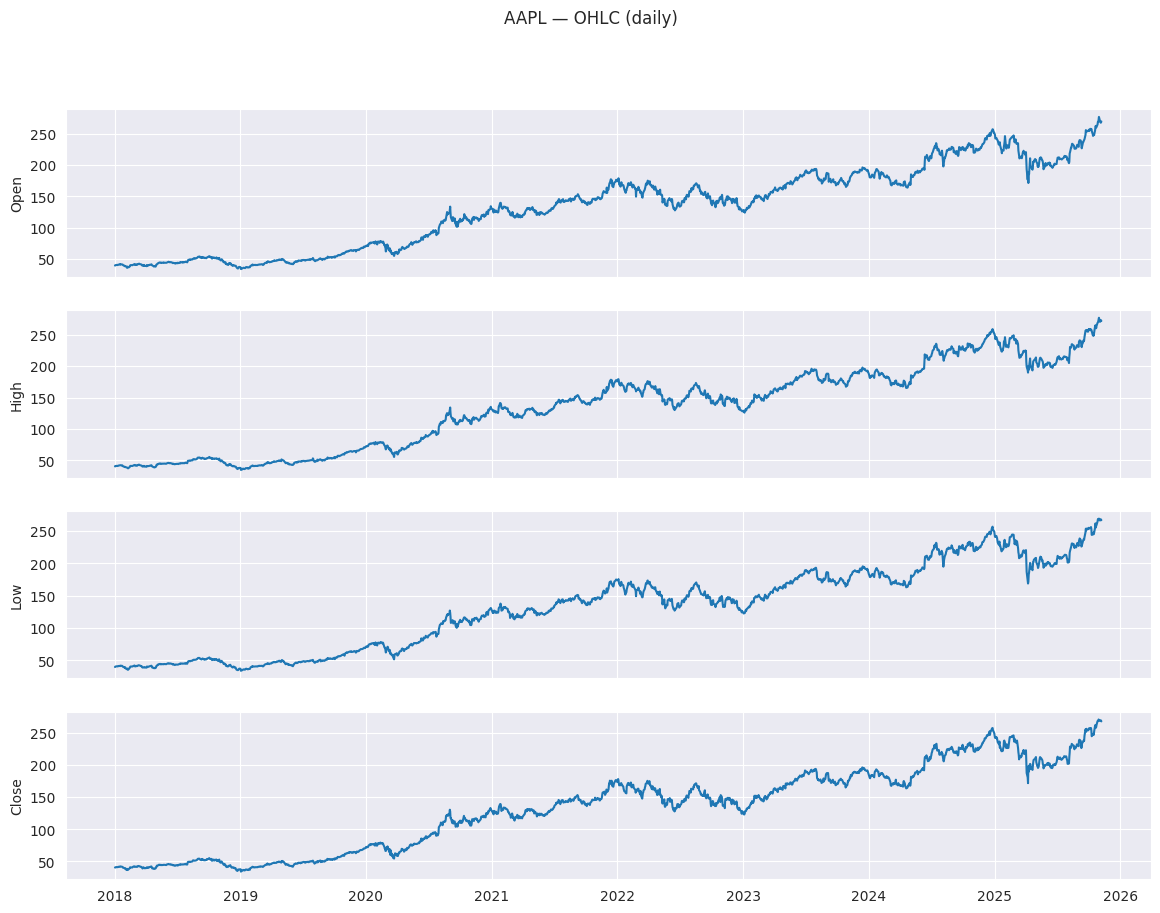

TypeError: only length-1 arrays can be converted to Python scalars

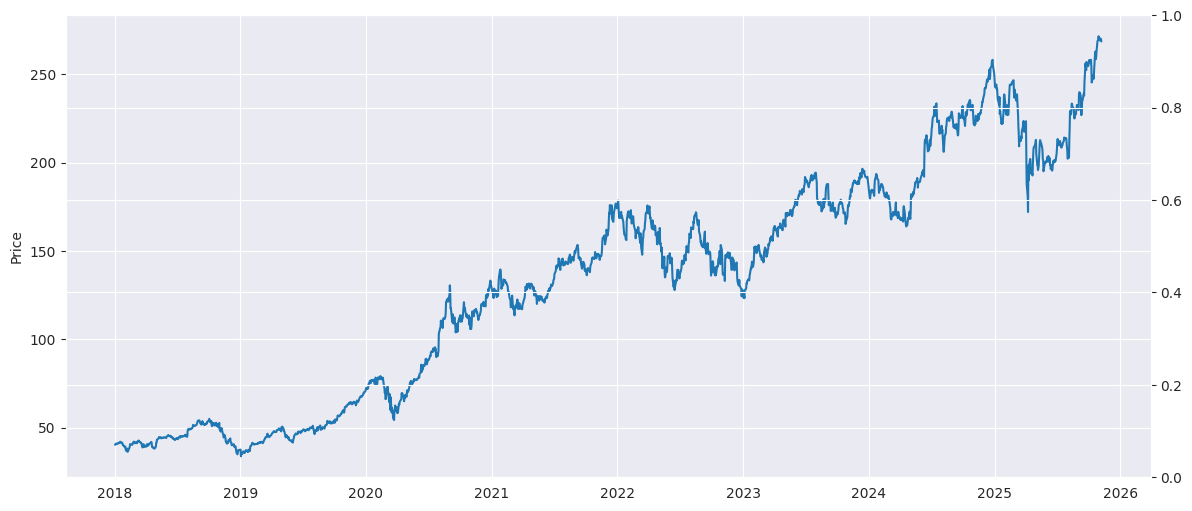

In [ ]:
# 4-subplot layout: Open/High/Low/Close
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(14,10))
axes[0].plot(df.index, df['Open']); axes[0].set_ylabel('Open')
axes[1].plot(df.index, df['High']); axes[1].set_ylabel('High')
axes[2].plot(df.index, df['Low']);  axes[2].set_ylabel('Low')
axes[3].plot(df.index, df['Close']);axes[3].set_ylabel('Close')
fig.suptitle(f"{TICKER} — OHLC (daily)")
plt.show()

# Overlay volume as a separate axis under price
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df.index, df['Close'], label='Close')
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.bar(df.index, df['Volume'], alpha=0.2, label='Volume')
ax2.set_ylabel('Volume')

ax1.set_title(f"{TICKER} — Close Price and Volume")
fig.legend(loc="upper left", bbox_to_anchor=(0.12,0.92))
plt.show()


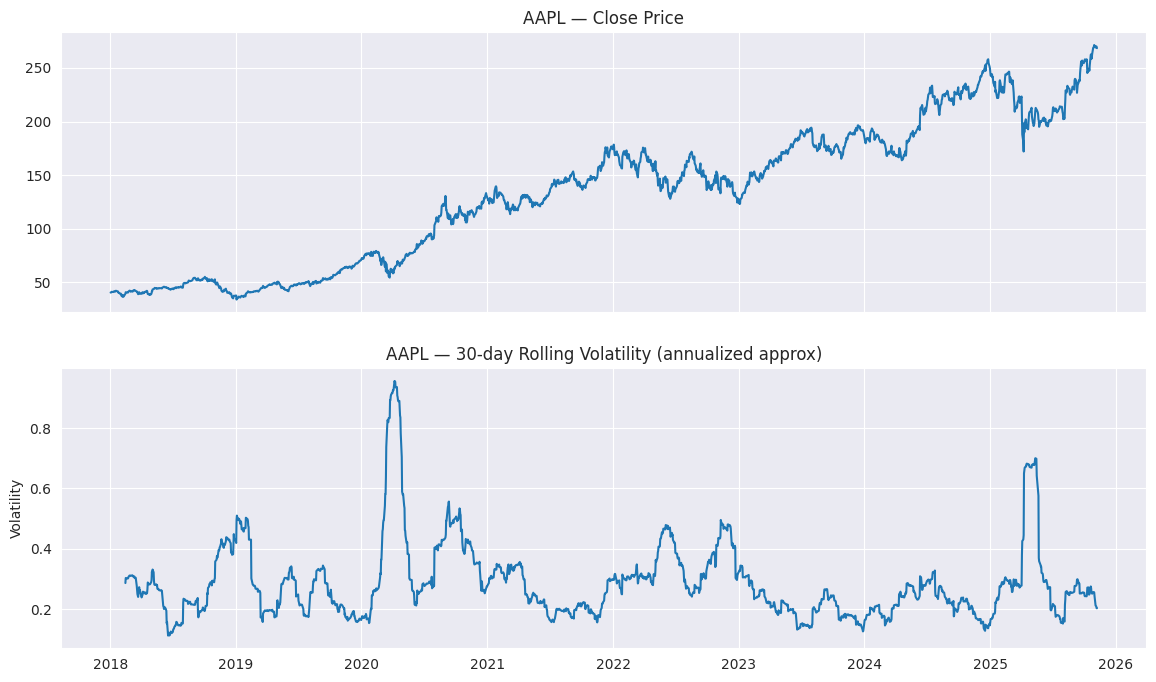

In [ ]:
# Daily returns
df['returns'] = df['Close'].pct_change()

# Rolling volatility (30-day)
df['volatility30'] = df['returns'].rolling(window=30).std() * np.sqrt(252)  # annualized approx

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(14,8))
ax1.plot(df['Close']); ax1.set_title(f"{TICKER} — Close Price")
ax2.plot(df['volatility30']); ax2.set_title(f"{TICKER} — 30-day Rolling Volatility (annualized approx)")
ax2.set_ylabel('Volatility')
plt.show()


pmdarima not installed; using fallback ARIMA(5,1,0). Install pmdarima for auto selection.
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1989
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -4667.020
Date:                Sun, 09 Nov 2025   AIC                           9346.040
Time:                        06:39:40   BIC                           9379.594
Sample:                    01-02-2018   HQIC                          9358.365
                         - 08-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0061      0.012      0.532      0.595      -0.017       0.029
ar.L2          0.0250      0.016      1.5

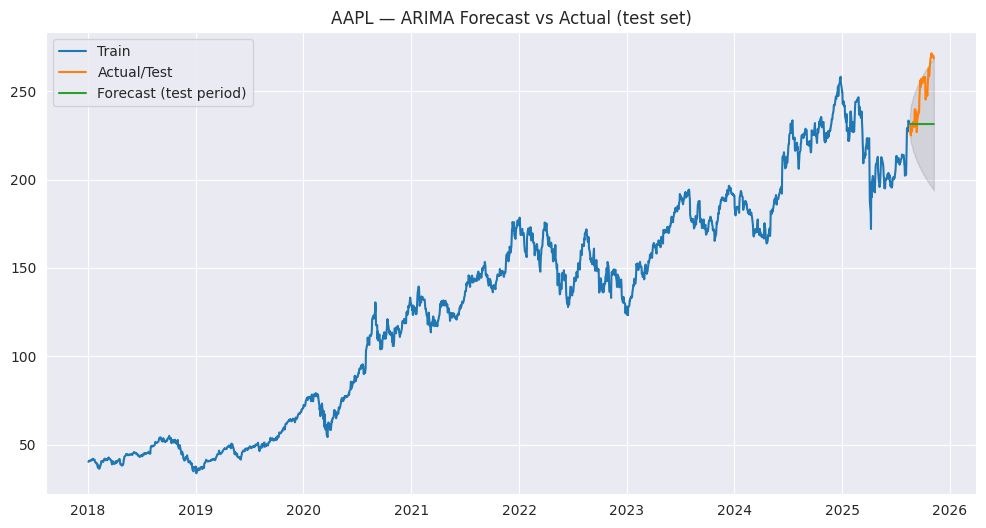

              forecast    lower_ci    upper_ci
2025-11-10  268.455955  263.397615  273.514296
2025-11-11  268.437214  261.225237  275.649191
2025-11-12  268.485212  259.591008  277.379415
2025-11-13  268.498799  258.285669  278.711930
2025-11-14  268.520646  257.154309  279.886982


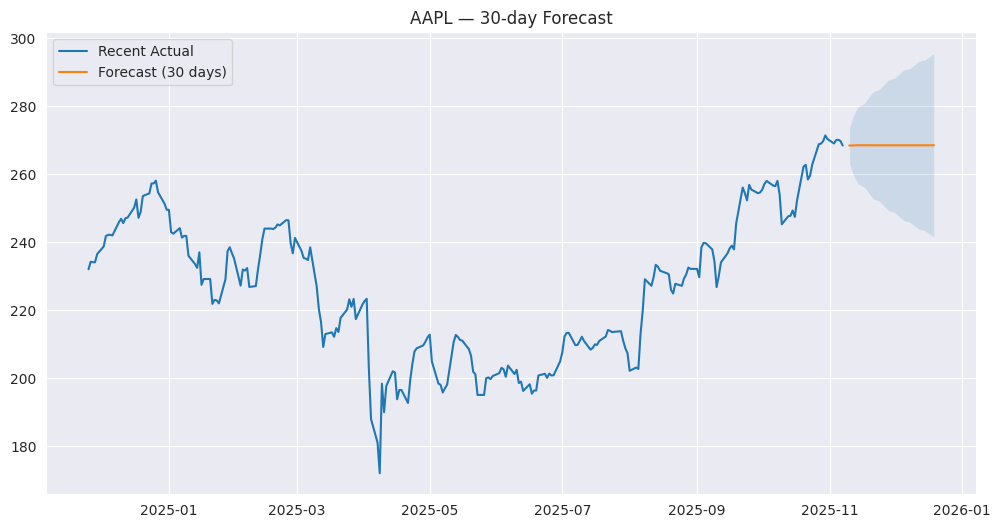

In [ ]:
# Prepare series
series = df['Close'].asfreq('B').ffill()  # business-day frequency
series = series[-(len(series)):]

# Train/test split: last 60 business days as test (so we can evaluate short-term accuracy)
test_size = 60
train, test = series[:-test_size], series[-test_size:]

# Auto ARIMA selection (if pmdarima available)
if has_pmdarima:
    print("Using pmdarima.auto_arima to select order...")
    arima_model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, max_p=5, max_q=5)
    print("Selected order:", arima_model.order)
    # Fit using statsmodels' SARIMAX for convenient forecasting
    order = arima_model.order
    model = sm.tsa.SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
else:
    # fallback: quick ADF check and simple ARIMA(5,1,0) or (1,1,1)
    print("pmdarima not installed; using fallback ARIMA(5,1,0). Install pmdarima for auto selection.")
    order = (5,1,0)
    model = sm.tsa.SARIMAX(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

# In-sample diagnostics
print(res.summary())

# Forecast test_size days to compare with test
pred_test = res.get_forecast(steps=test_size)
pred_test_mean = pred_test.predicted_mean
pred_test_ci = pred_test.conf_int()

# Evaluate with RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test, pred_test_mean))
mape = (np.mean(np.abs((test - pred_test_mean)/test)))*100

print(f"Test RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# Plot test vs forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual/Test')
plt.plot(pred_test_mean.index, pred_test_mean, label='Forecast (test period)')
plt.fill_between(pred_test_ci.index, pred_test_ci.iloc[:,0], pred_test_ci.iloc[:,1], color='k', alpha=0.1)
plt.legend(); plt.title(f"{TICKER} — ARIMA Forecast vs Actual (test set)")
plt.show()

# Now re-fit on full series and forecast 30 business days into future
res_full = sm.tsa.SARIMAX(series, order=res.model_orders.get('arima', order) if hasattr(res, 'model_orders') else order,
                         enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
forecast_steps = 30
forecast = res_full.get_forecast(steps=forecast_steps)
fc_mean = forecast.predicted_mean
fc_ci = forecast.conf_int()

# Print forecast table
fc_df = pd.DataFrame({
    "forecast": fc_mean,
    "lower_ci": fc_ci.iloc[:,0],
    "upper_ci": fc_ci.iloc[:,1]
})
print(fc_df.head())

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(series.index[-250:], series[-250:], label='Recent Actual')
plt.plot(fc_mean.index, fc_mean, label='Forecast (30 days)')
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.15)
plt.title(f"{TICKER} — 30-day Forecast")
plt.legend()
plt.show()


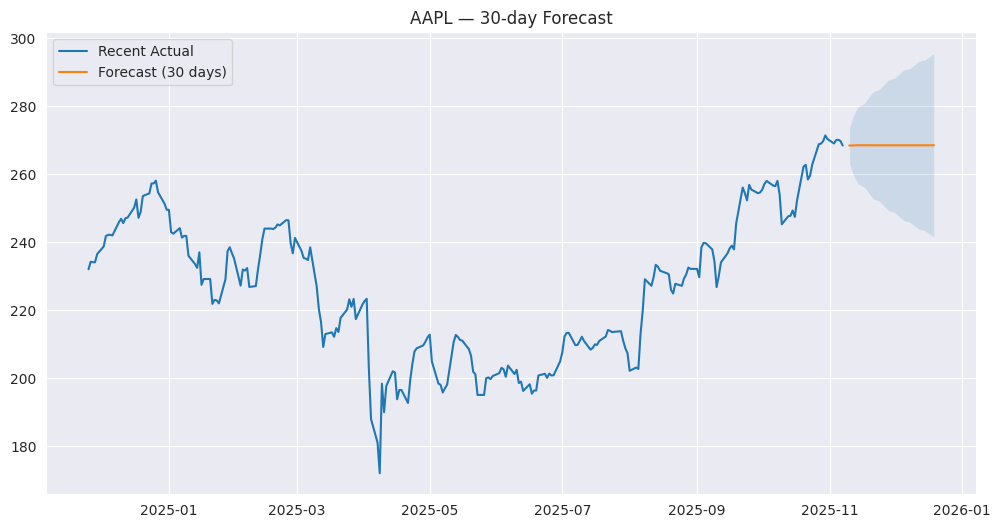

In [ ]:
# Example: save the last forecast plot
plt.figure(figsize=(12,6))
plt.plot(series.index[-250:], series[-250:], label='Recent Actual')
plt.plot(fc_mean.index, fc_mean, label='Forecast (30 days)')
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.15)
plt.title(f"{TICKER} — 30-day Forecast")
plt.legend()
plt.savefig(f"{TICKER}_30day_forecast.png", dpi=150, bbox_inches='tight')

# Save forecast dataframe to csv
fc_df.to_csv(f"{TICKER}_30day_forecast.csv")
